# Лабораторная работа №1: Поэлементные преобразования изображений

*Вариант 1*

Выполнил:

студент группы 6132-010402D

Баканов Дмитрий

In [1]:
from PIL import Image
from matplotlib.pylab import *
from matplotlib import pyplot as plt
import numpy as np
import cv2
from typing import Any, Dict, Optional, Tuple

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline


IMAGE_PATH = "./images/Lenna.png"


def plot_image(image: np.ndarray, is_gray: bool = True) -> None:
    """Функция отрисовки изображения."""
    axis("off")
    imshow(image, cmap=plt.get_cmap('gray') if is_gray else None)

def get_and_plot_hist(
        grayscale_image: np.ndarray,
        plot_title: str = None,
        nbr_bins: int = 256,
        plot_cdf: bool = False,
        return_values: bool = False,
) -> Optional[Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]]:
    """Функция для отраисовки гистограммы изображения и возвращения значений функции и плотности распределения."""
    if len(grayscale_image.shape) < 2:
        return
    figure(figsize=(10, 5))
    if plot_title:
        title(plot_title)
    image_hist, bins = np.histogram(grayscale_image.flatten(), nbr_bins, [0, 256])
    cdf = image_hist.cumsum() # функция распределения
    norm_cdf = cdf * float(image_hist.max()) / cdf.max()
    if plot_cdf:
        plot(norm_cdf, color='b')
        hist(grayscale_image.flatten(), nbr_bins, [0, 256], color='r')
        xlim([0, 256])
        legend(("функция распределения", "гистограмма"), loc="upper left")
    else:
        hist(grayscale_image.flatten(), bins=nbr_bins, density=True)
    grid(True)
    show()
    if return_values:
        return image_hist, bins, cdf, norm_cdf

*Задание 1. Считать цветное rgb изображение.*

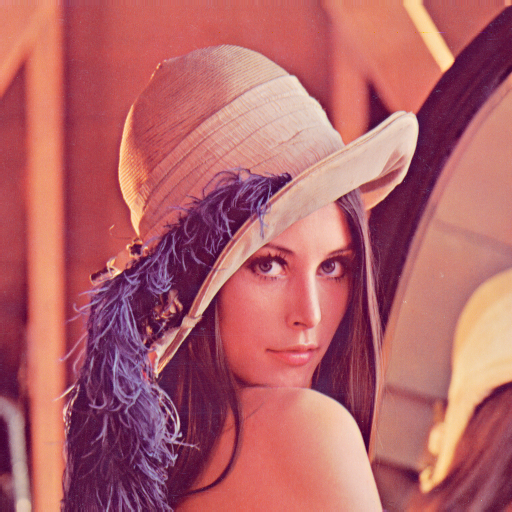

In [2]:
image = Image.open(IMAGE_PATH)
image

In [3]:
np.array(image).shape

(512, 512, 3)

*Задание 2. Преобразовать изображение в градации серого*

Для преобразования изображения в оттенки серого можно воспользоваться формулой:

$$ Y = 0.2126 * R + 0.7152 * G + 0.0722 *  B $$

In [4]:
def get_grayscale_image(rgb_image) -> np.ndarray:
    array_image = np.array(rgb_image)
    rows, cols, _ = array_image.shape
    grayscale_image = np.zeros((rows, cols))
    for i in range(rows):
        for j in range(rows):
            grayscale_image[i, j] = int(0.2126 * array_image[i, j][0] + 0.7152 * array_image[i, j][1] + 0.0722 * array_image[i, j][2])
    return grayscale_image.astype(np.uint8)

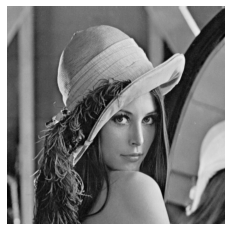

In [5]:
gray_image = get_grayscale_image(image)
plot_image(gray_image)

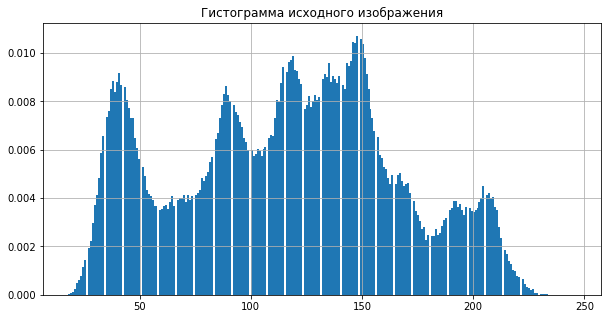

In [6]:
get_and_plot_hist(gray_image, plot_title="Гистограмма исходного изображения")

*Задание 3. Написать функцию реализации препарирования изображения*

В данном варианте функция препарирования представляет собой ступенчатую функцию вида:

\begin{equation*}
f(x) =
 \begin{cases}
   a &\text{\:if b < x < c}\\
   0 &\text{\:else}
 \end{cases}
\end{equation*}

$$a,\:b\:and\:с - const$$

In [7]:
def prep_func(x, a: int = 255, b: int = 85, c: int = 167) -> int:
    """Функция препарирования.
    a - значение интенсивности при попадании яркости в интервал,
    b - левая граница интервала,
    с - правая граница инервала
    """
    if b < x < c:
        return a
    else:
        return 0

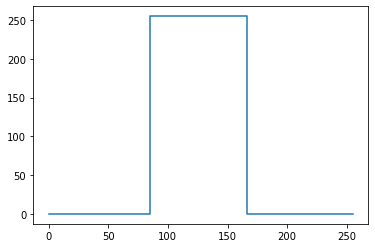

In [8]:
# изобразим ее
x_list = range(0, 256)
y_list = [prep_func(x) for x in x_list]
plt.step(x_list, y_list)

*Задание 4. По гистограмме изображения определить значение порога яркостей, обеспечивающего оптимальное разделение объекта и фона. Осуществить пороговую обработку входного изображения с найденным пороговым значением:*

* *__Вход:__ изображение из пункта 2*
* *__Вывод:__ входное и результирующие изображение и их гистограммы соответственно*
* *Порог определить на глаз по гистограмме*

In [9]:
def get_threshold_image(grayscale_image: np.ndarray, threshold: int = 100) -> np.ndarray:
    """Функция, выполняющая пороговую обработку."""
    rows, cols = grayscale_image.shape
    threshold_image = np.zeros((rows, cols))
    for i in range(rows):
        for j in range(cols):
            threshold_image[i, j] = grayscale_image[i, j] if grayscale_image[i, j] > threshold else 0
    get_and_plot_hist(threshold_image, plot_title="Гистограмма после пороговой обработки")
    return threshold_image

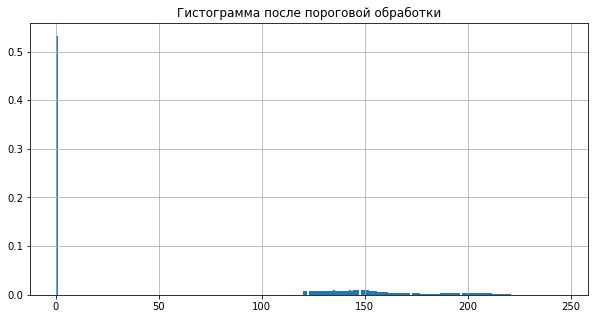

In [10]:
threshold_image = get_threshold_image(gray_image, threshold=120)

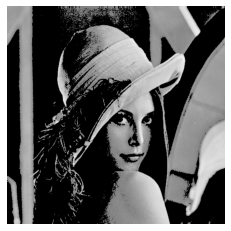

In [11]:
plot_image(threshold_image)

*Задание 5. Сделать пороговую обработку методом `Otsu` (Функция OpenCV)*
* *__Вход:__ изображение из пункта 2*
* *__Вывод:__ входное и результирующие изображение и их гистограммы соответственно*


In [12]:
opencv_threshold, opencv_threshold_image = cv2.threshold(gray_image, 0, 255, cv2.THRESH_OTSU)

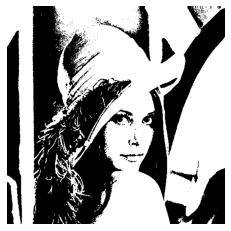

In [13]:
plot_image(opencv_threshold_image)

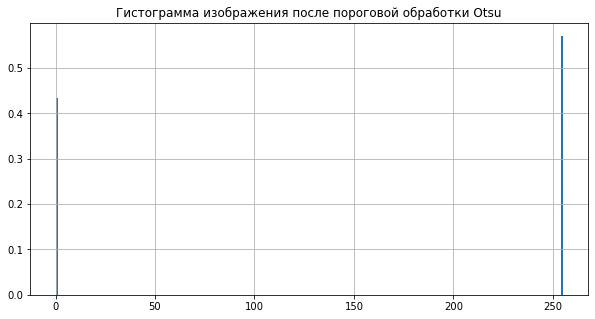

In [14]:
get_and_plot_hist(opencv_threshold_image, plot_title="Гистограмма изображения после пороговой обработки Otsu")

*Задание 6. Определить динамический диапазон входного изображения. Осуществить линейное контрастирование входного изображения в заданный динамический диапазон яркостей*
* *__Вход:__ изображение у которого диапазон не на всем промежутке [0,255]*
* *__Вывод:__ входное и результирующие изображение и их гистограммы соответственно*
* *Вычислить коэффициенты $ a $ и $ b $. Сделать преобразование вида $ g =a*f+b $*

In [15]:
def linear_contrast(grayscale_image: np.ndarray) -> Dict[str, Any]:
    """Функция для проведения линейного контрастирования."""
    results = {
        "original_range": None,
        "original_image": None,
        "a": None,
        "b": None,
        "result_range": None,
        "result_image": None
    }

    flatten_image = grayscale_image.flatten()
    x_min = flatten_image.min()
    x_max = flatten_image.max()
    results["original_range"] = (x_min, x_max)
    results["original_image"] = grayscale_image.copy()

    y_min = 0
    y_max = 255
    a = (y_max - y_min) / (x_max - x_min)
    b = (y_min * x_max - y_max * x_min) / (x_max - x_min)
    results["a"] = a
    results["b"] = b

    rows, cols = grayscale_image.shape
    result_image = np.zeros((rows, cols))

    for i in range(rows):
        for j in range(cols):
            result_image[i, j] = int(a * grayscale_image[i, j] + b)

    result_image = result_image.astype(np.uint8)

    flatten_result_image = result_image.flatten()
    results["result_range"] = (flatten_result_image.min(), flatten_result_image.max())
    results["result_image"] = result_image.copy()

    return results

In [16]:
linear_contrast_results = linear_contrast(gray_image)

In [17]:
print(f"Линейное преобразование для данного изображения: f = {linear_contrast_results['a']} * x + {linear_contrast_results['b']}")

Линейное преобразование для данного изображения: f = 1.118421052631579 * x + -20.13157894736842


Динамический диапазон исходного изображения: (18, 246)


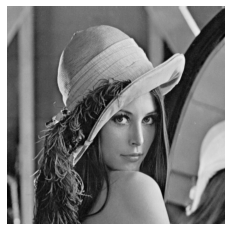

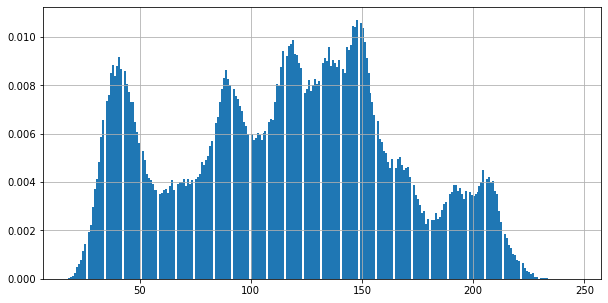

In [18]:
print(f"Динамический диапазон исходного изображения: {linear_contrast_results['original_range']}")
plot_image(linear_contrast_results['original_image'])
get_and_plot_hist(linear_contrast_results['original_image'])

Динамический диапазон после линейного контрастирования: (0, 255)


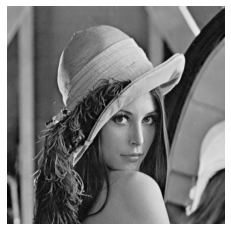

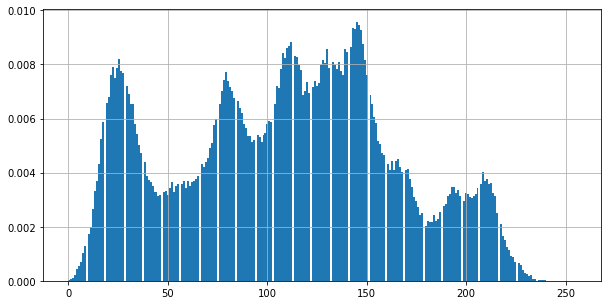

In [19]:
print(f"Динамический диапазон после линейного контрастирования: {linear_contrast_results['result_range']}")
plot_image(linear_contrast_results['result_image'])
get_and_plot_hist(linear_contrast_results['result_image'])

*Задание 7. Сделать эквализацию гистограммы изображения*
* *__Вход:__ изображение из пункта 2*
* *__Вывод:__ входное и результирующие изображение и их гистограммы соответственно*

In [20]:
def image_equalization(grayscale_image: np.ndarray) -> np.ndarray:
    """Функция проведения эквализации гистограммы изображения."""
    image_hist, bins, cdf, norm_cdf = get_and_plot_hist(grayscale_image, plot_title="Гистограмма и функция распределения исходного изображения", plot_cdf=True, return_values=True)
    cdf_mask = np.ma.masked_equal(cdf, 0)
    cdf_mask = ((cdf_mask - cdf_mask.min())*255/(cdf_mask.max()-cdf_mask.min()))
    result_cdf = np.ma.filled(cdf_mask, 0).astype(np.uint8)
    result_image = result_cdf[grayscale_image]
    get_and_plot_hist(result_image, plot_title="Гистограмма и функция распределения эквализированного изображения", plot_cdf=True)
    return result_image

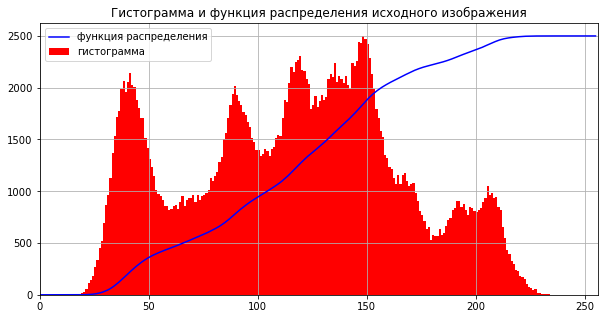

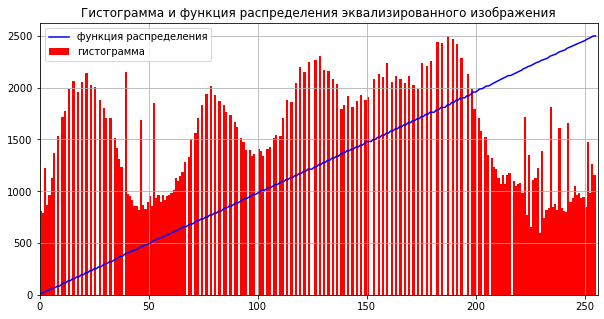

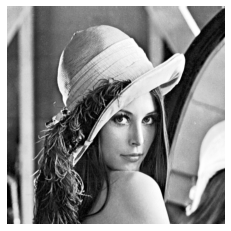

In [21]:
image_equal = image_equalization(gray_image)
plot_image(image_equal)

*Задание 8. Сделать эквализацию методом `CLAHE` (Функция OpenCV)*
* *__Вход:__ изображение из пункта 2*
* *__Вывод:__ входное и результирующие изображение и их гистограммы соответственно*

In [22]:
opencv_image_equal = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8)).apply(gray_image)

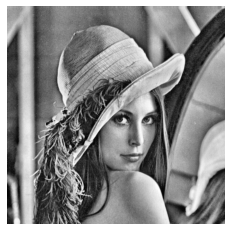

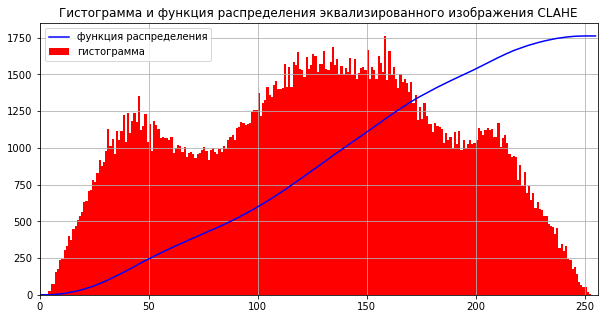

In [23]:
plot_image(opencv_image_equal)
get_and_plot_hist(opencv_image_equal, plot_title="Гистограмма и функция распределения эквализированного изображения CLAHE", plot_cdf=True)

*Задание 9. Осуществить препарирование изображения с заданной препарирующей функцией*
* *__Вход:__ изображение из пункта 2*
* *__Вывод:__ входное и результирующие изображение и их гистограммы соответственно. График препарирующий функции.*
* Пороги в препарирующей функции выбирать самостоятельно

In [24]:
def image_preparation(grayscale_image: np.ndarray) -> np.ndarray:
    rows, cols = grayscale_image.shape
    new_image = np.zeros((rows, cols))
    for i in range(rows):
        for j in range(cols):
            x = grayscale_image[i, j]
            new_image[i, j] = prep_func(x)
    get_and_plot_hist(new_image, plot_title="Гистограмма препарированного изображения")
    return new_image.astype(np.uint8)

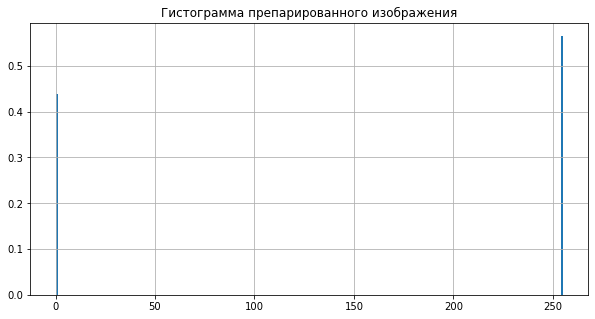

In [25]:
prep_image = image_preparation(gray_image)

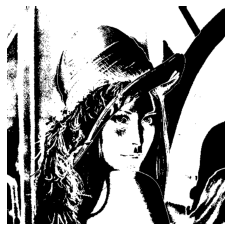

In [26]:
plot_image(prep_image)